# 02 · Trend Analysis — Baltimore IGS
# -----------------------------------
# Safe to run after 01_ingest_and_eda.ipynb
# Requires: pandas, numpy, matplotlib (no parquet engines needed)

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Paths ---
ROOT = Path.cwd().parents[0]  # project root (igs-analysis-baltimore)
CLEAN_DIR = ROOT / "data_clean"
VIS_DIR = ROOT / "visuals"
VIS_DIR.mkdir(parents=True, exist_ok=True)

merged_path = CLEAN_DIR / "baltimore_igs_merged.csv"
deltas_path = CLEAN_DIR / "baltimore_igs_yoy_deltas.csv"

# --- Load data ---
print("Looking for cleaned files in:", CLEAN_DIR.resolve())
assert merged_path.exists(), f"❌ Missing cleaned file: {merged_path}"
merged = pd.read_csv(merged_path)

if deltas_path.exists():
    deltas = pd.read_csv(deltas_path)
    print("Loaded deltas file.")
else:
    deltas = None
    print("⚠️ No deltas file found — will compute YoY internally.")

print("✅ Loaded merged dataset with shape:", merged.shape)
merged.head()


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
ROOT = Path.cwd().parents[0]          # project root (igs-analysis-baltimore)
CLEAN_DIR = ROOT / "data_clean"
VIS_DIR = ROOT / "visuals"
VIS_DIR.mkdir(parents=True, exist_ok=True)

# Prefer Baltimore City subset; fall back to full Baltimore file
candidates = [
    CLEAN_DIR / "igs_baltimore_city_2020_2024.parquet",
    CLEAN_DIR / "igs_baltimore_city_2020_2024.csv",
    CLEAN_DIR / "igs_baltimore_2020_2024.parquet",
    CLEAN_DIR / "igs_baltimore_2020_2024.csv",
]

clean_path = next((p for p in candidates if p.exists()), None)
assert clean_path is not None, f"No cleaned files found in {CLEAN_DIR.resolve()}"

clean_path


PosixPath('/Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/igs_baltimore_city_2020_2024.csv')

In [3]:
if clean_path.suffix == ".parquet":
    df = pd.read_parquet(clean_path)
else:
    df = pd.read_csv(clean_path)

# Coerce types we need
if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

if 'inclusive_growth_score' in df.columns:
    df['inclusive_growth_score'] = pd.to_numeric(df['inclusive_growth_score'], errors='coerce')

# Basic sanity
print("Loaded:", clean_path.name, "| shape:", df.shape)
print("Years:", sorted(df['year'].dropna().unique().tolist()))
df.head()


Loaded: igs_baltimore_city_2020_2024.csv | shape: (1000, 8)
Years: [2020, 2021, 2022, 2023, 2024]


,geoid,year,county,state,inclusive_growth_score,is_an_opportunity_zone,county_fips,state_fips
0,24510150800,2020,Baltimore city,Maryland,36.0,NaN,24510,24
1,24510150800,2021,Baltimore city,Maryland,40.0,NaN,24510,24
2,24510150800,2022,Baltimore city,Maryland,34.0,NaN,24510,24
3,24510150800,2023,Baltimore city,Maryland,38.0,NaN,24510,24
4,24510150800,2024,Baltimore city,Maryland,38.0,NaN,24510,24


In [4]:
# Keep just what we need
cols = ['geoid','year','inclusive_growth_score','county','state']
cols = [c for c in cols if c in df.columns]
d = df[cols].dropna(subset=['geoid','year','inclusive_growth_score']).copy()

# Sort and compute YoY delta within each tract
d = d.sort_values(['geoid','year'])
d['igs_yoy_delta'] = d.groupby('geoid')['inclusive_growth_score'].diff()

# 2020→2024 change per tract (net change)
net_change = (
    d.groupby('geoid')
     .apply(lambda g: g.loc[g['year'].idxmax(), 'inclusive_growth_score'] -
                       g.loc[g['year'].idxmin(), 'inclusive_growth_score'])
     .rename('igs_change_2020_2024')
     .reset_index()
)

print("Rows with YoY deltas:", d['igs_yoy_delta'].notna().sum())
net_change.head()


Rows with YoY deltas: 790


/var/folders/k2/vf202xq51_zbprqvw3dspdw40000gn/T/ipykernel_44651/2988568781.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g['year'].idxmax(), 'inclusive_growth_score'] -


,geoid,igs_change_2020_2024
0,24510010100,4.0
1,24510010200,0.0
2,24510010300,-3.0
3,24510010400,-2.0
4,24510010500,-1.0


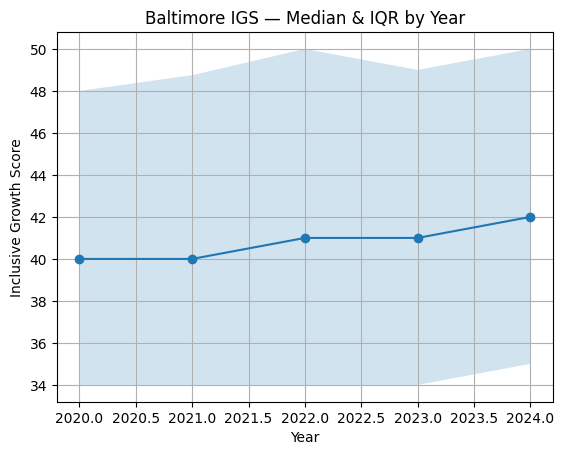

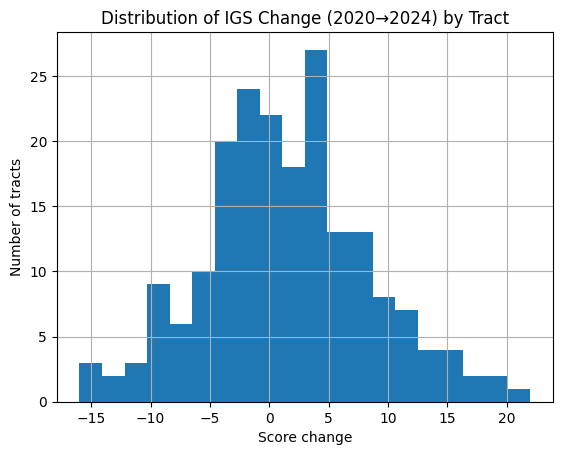

In [5]:
# Median & IQR by year
summary = (d.groupby('year')['inclusive_growth_score']
             .agg(['count','median','quantile'])
             .rename(columns={'quantile':'q'})
          )
# recompute with explicit quantiles
g = d.groupby('year')['inclusive_growth_score']
summary = pd.DataFrame({
    'count': g.size(),
    'median': g.median(),
    'q25': g.quantile(0.25),
    'q75': g.quantile(0.75),
}).reset_index()

# Plot median with IQR band
plt.figure()
plt.plot(summary['year'], summary['median'], marker='o')
plt.fill_between(summary['year'], summary['q25'], summary['q75'], alpha=0.2)
plt.title('Baltimore IGS — Median & IQR by Year')
plt.xlabel('Year')
plt.ylabel('Inclusive Growth Score')
plt.grid(True)
plt.show()

# Histogram of 2020→2024 net change per tract
plt.figure()
plt.hist(net_change['igs_change_2020_2024'].dropna(), bins=20)
plt.title('Distribution of IGS Change (2020→2024) by Tract')
plt.xlabel('Score change')
plt.ylabel('Number of tracts')
plt.grid(True)
plt.show()


In [6]:
DELTA_CSV = CLEAN_DIR / "baltimore_igs_yoy_deltas.csv"
NETCHANGE_CSV = CLEAN_DIR / "baltimore_igs_change_2020_2024.csv"

d[['geoid','year','inclusive_growth_score','igs_yoy_delta']].to_csv(DELTA_CSV, index=False)
net_change.to_csv(NETCHANGE_CSV, index=False)

print("Saved:")
print(" -", DELTA_CSV.name)
print(" -", NETCHANGE_CSV.name)


Saved:
 - baltimore_igs_yoy_deltas.csv
 - baltimore_igs_change_2020_2024.csv


In [11]:
# --- Load merged dataset if not already in memory ---
from pathlib import Path
import pandas as pd

CLEAN_DIR = Path.cwd().parents[0] / "data_clean"
merged_path = CLEAN_DIR / "baltimore_igs_merged.csv"

merged = pd.read_csv(merged_path)
print("Loaded merged dataset with shape:", merged.shape)
merged.head()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/baltimore_igs_merged.csv'

In [10]:
# --- Load cleaned dataset (pick best available) ---
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parents[0] if (Path.cwd().parents[0] / "data_clean").exists() else Path.cwd()
CLEAN_DIR = ROOT / "data_clean"

candidates = [
    CLEAN_DIR / "igs_baltimore_city_2020_2024.parquet",
    CLEAN_DIR / "igs_baltimore_city_2020_2024.csv",
    CLEAN_DIR / "igs_baltimore_2020_2024.parquet",
    CLEAN_DIR / "igs_baltimore_2020_2024.csv",
]
merged_path = next((p for p in candidates if p.exists()), None)
assert merged_path is not None, f"No cleaned files found in {CLEAN_DIR.resolve()}"

merged = pd.read_parquet(merged_path) if merged_path.suffix == ".parquet" else pd.read_csv(merged_path)
print("Loaded:", merged_path.name, "| shape:", merged.shape)

# normalize types
merged["year"] = pd.to_numeric(merged["year"], errors="coerce").astype("Int64")
merged["geoid"] = merged["geoid"].astype(str).str.zfill(11)

# find the score column
score_col = next((c for c in merged.columns if c.lower() in
                  {"inclusive_growth_score","igs_score","overall_score","score"}), None)
assert score_col is not None, f"No score column found. Columns: {merged.columns.tolist()}"
print("Using score column:", score_col)


Loaded: igs_baltimore_city_2020_2024.csv | shape: (1000, 8)
Using score column: inclusive_growth_score


In [12]:
## 5-Year Average IGS by Census Tract (Baltimore)

# --- Compute 5-year IGS averages per tract ---
tract_avgs = (
    merged.groupby("geoid")[score_col]
    .mean()
    .reset_index()
    .rename(columns={score_col: "igs_5yr_avg"})
)
print(f"Computed 5-year averages for {len(tract_avgs)} tracts.")
tract_avgs.head()


Computed 5-year averages for 200 tracts.


,geoid,igs_5yr_avg
0,24510010100,59.8
1,24510010200,53.2
2,24510010300,57.2
3,24510010400,58.6
4,24510010500,50.4


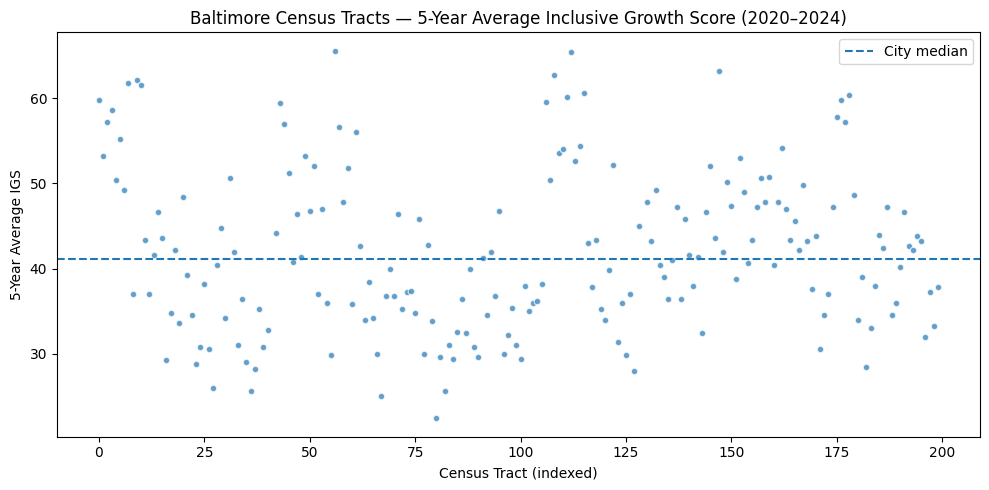

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.scatter(range(len(tract_avgs)), tract_avgs["igs_5yr_avg"],
            alpha=0.7, s=22, edgecolor="white")
plt.axhline(tract_avgs["igs_5yr_avg"].median(), linestyle="--", label="City median")
plt.title("Baltimore Census Tracts — 5-Year Average Inclusive Growth Score (2020–2024)")
plt.xlabel("Census Tract (indexed)"); plt.ylabel("5-Year Average IGS"); plt.legend()
plt.tight_layout(); plt.show()


In [14]:
out_avg = CLEAN_DIR / "baltimore_igs_5yr_avg.csv"
tract_avgs.to_csv(out_avg, index=False)
print("Saved:", out_avg)


Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/baltimore_igs_5yr_avg.csv


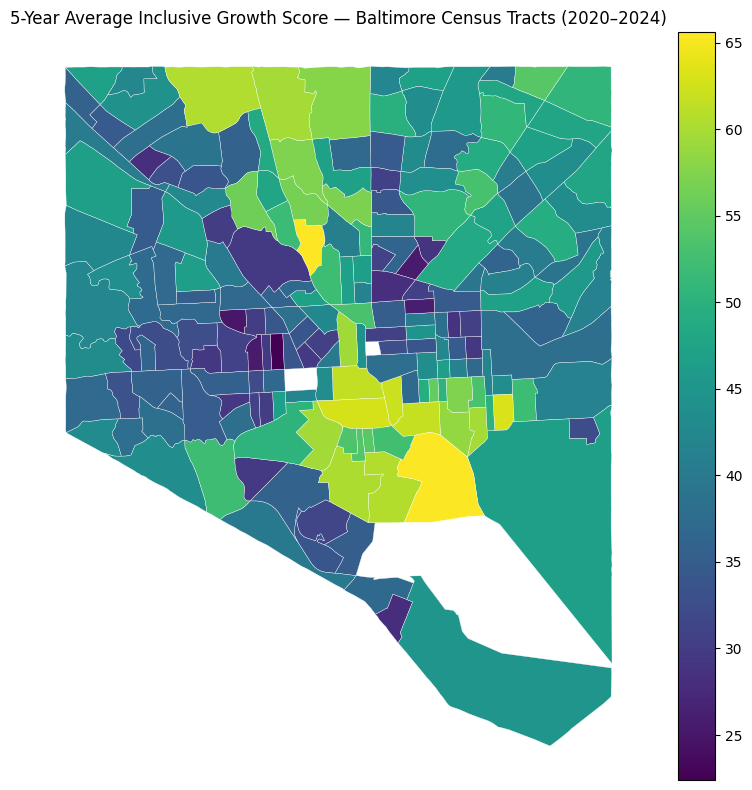

✅ Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/igs_5yr_avg_map.png


In [15]:
# === 5-year average IGS choropleth (Baltimore tracts) ===
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

ROOT = Path.cwd().parents[0] if (Path.cwd().parents[0] / "data").exists() else Path.cwd()
GEO = ROOT / "data" / "geo"
VIS = ROOT / "visuals"
VIS.mkdir(exist_ok=True, parents=True)

# Use the statewide TIGER tracts we downloaded for 03_mapping
# If you only have the ZIP, open the extracted folder (tl_2023_24_tract)
tiger_dir = GEO / "tl_2023_24_tract"
shp = next(tiger_dir.glob("*.shp"))
tracts = gpd.read_file(shp).to_crs(4326)

# Normalize key and filter to Baltimore City (county FIPS 24510)
tracts["geoid"] = tracts["GEOID"].astype(str).str.zfill(11)
tracts = tracts[tracts["geoid"].str.startswith("24510")].copy()

# Join 5-yr averages to geometry
g_avg = tracts.merge(tract_avgs, on="geoid", how="left")

# Plot
vmin, vmax = g_avg["igs_5yr_avg"].min(), g_avg["igs_5yr_avg"].max()
fig, ax = plt.subplots(figsize=(8, 8))
g_avg.plot(column="igs_5yr_avg", cmap="viridis", legend=True,
           vmin=vmin, vmax=vmax, edgecolor="white", linewidth=0.25, ax=ax)
ax.set_title("5-Year Average Inclusive Growth Score — Baltimore Census Tracts (2020–2024)")
ax.axis("off")
out = VIS / "igs_5yr_avg_map.png"
plt.tight_layout(); plt.savefig(out, dpi=180); plt.show()
print("✅ Saved:", out)
